# **Sentiment Analysis on Tweets**
Sentiment analysis, also known as opinion mining, is the process of identifying and categorizing emotions expressed in text data—typically as positive, negative, or neutral. It helps organizations and individuals understand the sentiment behind user-generated content, such as product reviews, social media posts, or customer feedback.

In the context of social media, sentiment analysis is particularly valuable due to the vast amount of real-time user opinions shared daily. Twitter, with its concise and public messages, provides an ideal dataset for analyzing public sentiment around topics, events, brands, or products.

By leveraging natural language processing (NLP) techniques and machine learning models, sentiment analysis can extract insights from tweets to support business decisions, brand monitoring, political analysis, and crisis management.

This project focuses on building a sentiment classifier using a dataset of tweets. The model aims to classify each tweet as positive or negative, helping reveal how people feel about certain topics at scale.

<br>

**Dataset:** [Kaggle Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140/data)

---

## **Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import emoji

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Prepare the dataset.

In [2]:
dataset_path = '../data/twt.csv'
column_names = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv(dataset_path, encoding='latin', delimiter=',', names=column_names)
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Drop unimportant columns and missing values.

In [3]:
df = df.drop(['id', 'date', 'flag', 'user'], axis=1)
df = df.dropna()
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Preprocess the data:
- convert the emojis into text
- lowercase everything
- remove urls, mentions and hashtags
- remove punctuations and special characters
- remove stopwords
- split into tokens

In [4]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [5]:
def clean_twts(twt):
    twt = twt.lower()  # Lowercase
    twt = re.sub(r"http\S+|www\S+|https\S+", '', twt)  # Remove URLs
    twt = re.sub(r"@\w+", '', twt)  # Remove mentions
    twt = re.sub(r"#", '', twt)  # Remove hashtag symbol, keep the word
    twt = emoji.demojize(twt)  # Convert emojis to text
    twt = re.sub(r"[^a-zA-Z\s]", '', twt)  # Remove punctuations and special characters
    twt = re.sub(r"\s+", ' ', twt).strip()  # Remove extra spaces
    tokens = twt.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Stem words
    
    return ' '.join(tokens)

cleaned_twts = df['text'].apply(clean_twts)
df['cleaned_text'] = cleaned_twts

In [6]:
df.head()

,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behav im mad cant see


Tokenize the data.

In [7]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_twts)
sequences = tokenizer.texts_to_sequences(cleaned_twts)
padded_sequences = pad_sequences(sequences, maxlen=30, padding='post', truncating='post')

print("Tokenized and padded sequences:")
print(padded_sequences)

Tokenized and padded sequences:
[[  50 1067 2992 ...    0    0    0]
 [ 601   13  224 ...    0    0    0]
 [3569  225   12 ...    0    0    0]
 ...
 [ 136 6103 6121 ...    0    0    0]
 [  58  212  185 ...    0    0    0]
 [  58    1    0 ...    0    0    0]]


Add into the dataframe.

In [8]:
df['padded_text'] = list(padded_sequences)
df['sentiment'] = df['sentiment'].map({4: 1, 0: 0})
df.head()

,sentiment,text,cleaned_text,padded_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that bummer shoulda got david carr third day,"[50, 1067, 2992, 14, 713, 7250, 1639, 5, 0, 0,..."
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...,"[601, 13, 224, 444, 364, 205, 239, 967, 83, 11..."
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound,"[3569, 225, 12, 871, 697, 505, 353, 3, 2747, 0..."
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,"[336, 660, 24, 2501, 8, 882, 0, 0, 0, 0, 0, 0,..."
4,0,"@nationwideclass no, it's not behaving at all....",behav im mad cant see,"[3982, 2, 462, 13, 23, 0, 0, 0, 0, 0, 0, 0, 0,..."


Split the dataset.

In [9]:
x = padded_sequences
y = df['sentiment']


x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
df

,sentiment,text,cleaned_text,padded_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that bummer shoulda got david carr third day,"[50, 1067, 2992, 14, 713, 7250, 1639, 5, 0, 0,..."
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...,"[601, 13, 224, 444, 364, 205, 239, 967, 83, 11..."
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound,"[3569, 225, 12, 871, 697, 505, 353, 3, 2747, 0..."
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,"[336, 660, 24, 2501, 8, 882, 0, 0, 0, 0, 0, 0,..."
4,0,"@nationwideclass no, it's not behaving at all....",behav im mad cant see,"[3982, 2, 462, 13, 23, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,woke school best feel ever,"[253, 83, 107, 24, 151, 0, 0, 0, 0, 0, 0, 0, 0..."
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview,"[1, 130, 176, 163, 1, 764, 0, 0, 0, 0, 0, 0, 0..."
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,readi mojo makeov ask detail,"[136, 6103, 6121, 294, 1502, 0, 0, 0, 0, 0, 0,..."
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happi th birthday boo alll time tupac amaru sh...,"[58, 212, 185, 400, 4233, 12, 9659, 1, 1, 0, 0..."


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=30),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=(None,30))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    x_train, y_train,
    epochs=12,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 371s 12ms/step - accuracy: 0.5072 - loss: 0.6906 - val_accuracy: 0.7718 - val_loss: 0.4793
Epoch 2/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 401s 13ms/step - accuracy: 0.7774 - loss: 0.4701 - val_accuracy: 0.7892 - val_loss: 0.4522
Epoch 3/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 381s 13ms/step - accuracy: 0.7961 - loss: 0.4371 - val_accuracy: 0.7919 - val_loss: 0.4437
Epoch 4/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 334s 11ms/step - accuracy: 0.8052 - loss: 0.4196 - val_accuracy: 0.7893 - val_loss: 0.4474
Epoch 5/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 353s 12ms/step - accuracy: 0.8127 - loss: 0.4073 - val_accuracy: 0.7919 - val_loss: 0.4479
Epoch 6/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 355s 12ms/step - accuracy: 0.8210 - loss: 0.3931 - val_accuracy: 0.7912 - val_loss: 0.4472
Epoch 7/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 359s 12ms/step - accuracy: 0.8279 - loss: 0.3801 - val_accuracy: 0.7886 - val_loss: 0.4523
Epoch 8/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 378s 13ms/s

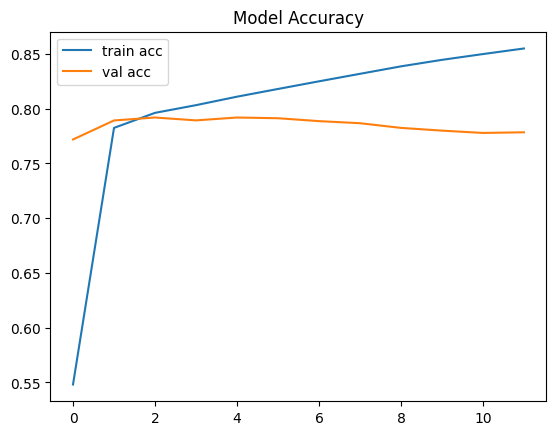

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [16]:
preds = model.predict(x_val)
preds_binary = (preds > 0.5).astype(int)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, preds_binary))
print(confusion_matrix(y_test, preds_binary))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49    159790
           1       0.50      0.51      0.51    160210

    accuracy                           0.50    320000
   macro avg       0.50      0.50      0.50    320000
weighted avg       0.50      0.50      0.50    320000

[[77434 82356]
 [78215 81995]]


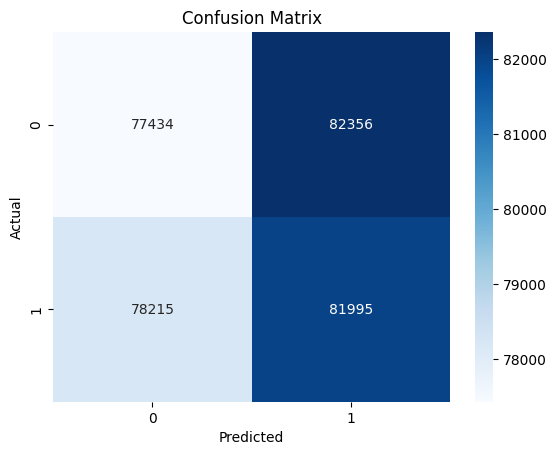

In [18]:
cm = confusion_matrix(y_test, preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Initial training results: the model can be improved. Will try again.  
Second attempt: model improved slightly. Will try again.  
Third attempt: tried adding more epochs and batches. Will try again.  